### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import os
from torchvision import transforms
import torch.optim as optim
import cv2
import math
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Pre-trained autoencoder

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, 32, 32)
            nn.ReLU()
        )

        # --- Decoder ---
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # (B, 1, 256, 256)
            nn.Sigmoid()  # for binary mask reconstruction
        )

    def forward(self, x):
        # --- Encoding ---
        x1 = self.enc1(x)  # (B, 16, 128, 128)
        x2 = self.enc2(x1) # (B, 32, 64, 64)
        x3 = self.enc3(x2) # (B, 64, 32, 32)

        # --- Decoding ---
        d3 = self.dec3(x3)           # (B, 32, 64, 64)
        d3 = torch.cat([d3, x2], 1)  # (B, 64, 64, 64)

        d2 = self.dec2(d3)           # (B, 16, 128, 128)
        d2 = torch.cat([d2, x1], 1)  # (B, 32, 128, 128)

        out = self.dec1(d2)          # (B, 1, 256, 256)
        return out


In [3]:
# Reconstruct the model and optimizer exactly as before
autoencoder = Autoencoder().to(device)  # match your original config
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Load checkpoint
checkpoint = torch.load("autoencoder_checkpoint.pth", map_location=torch.device(device))  # use 'cuda' if needed
autoencoder
# Restore weights and optimizer state
autoencoder.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

autoencoder.eval()  # or model.train() if resuming training

print(f"Loaded model from epoch {start_epoch} with loss {last_loss:.4f}")


Loaded model from epoch 70 with loss 0.0032


In [241]:
def extract_coordinates_from_heatmap(heatmap_tensor, threshold=0.8, center=None, degrees=True):
    heatmap = heatmap_tensor.squeeze().cpu().numpy()  # (H, W)
    H, W = heatmap.shape
    binary = (heatmap > threshold).astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    if center is None:
        center = (W // 2, H // 2)

    cx, cy = center
    polar_coords = []

    for i in range(1, num_labels):  # skip background
        x, y = centroids[i]
        dx, dy = x - cx, y - cy
        radius = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)
        if degrees:
            angle = np.degrees(angle) % 360 # Convert to degrees and normalize to [0, 360)
        polar_coords.append((radius, angle/ 360.0))  # Normalize angle to [0, 1]

    # Sort by radius (distance from center)
    polar_coords.sort(key=lambda x: x[0])

    return polar_coords

Detected corners: [(np.float64(5.024937810560445), np.float64(0.7658627587152768)), (np.float64(6.098907762893036), np.float64(0.19097081803574076)), (np.float64(37.63517304331149), np.float64(0.9962993892948067)), (np.float64(40.90621238519678), np.float64(0.05559386187778482)), (np.float64(88.46134866674547), np.float64(0.5298209942662))]
Length: 5


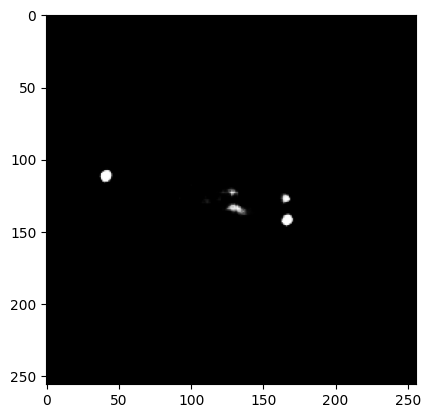

In [242]:
def convert_npfloat_list(data):
    return [(round(float(r), 2), round(float(a), 2)) for r, a in data]


def predict_image(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    img = np.expand_dims(img, axis=0)  # (1, 1, H, W)
    img_tensor = torch.tensor(img).to(device)

    autoencoder.eval()
    with torch.no_grad():
        output = autoencoder(img_tensor)
        heatmap = output[0]  # (1, H, W)
        corner_coords = extract_coordinates_from_heatmap(heatmap, threshold=0.75)
        print("Detected corners:", corner_coords)
        print("Length:", len(corner_coords))

    output_img = output.cpu().squeeze().numpy()
    return output_img

# Example usage:
result_img = predict_image("synthetic_dataset_complex\sample_0005\img1.png")
plt.imshow(result_img, cmap="gray")
plt.show()

Detected corners: [(np.float64(36.33589499600256), np.float64(0.8869728902939429)), (np.float64(41.019960028764686), np.float64(0.945170513981788)), (np.float64(88.13647105973892), np.float64(0.417086645199325))]
Length: 3


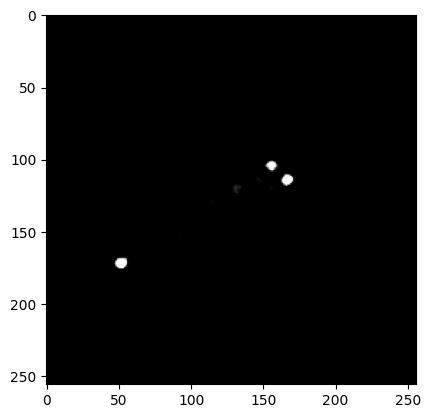

In [243]:
def convert_npfloat_list(data):
    return [(round(float(r), 2), round(float(a), 2)) for r, a in data]


def predict_image(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    img = np.expand_dims(img, axis=0)  # (1, 1, H, W)
    img_tensor = torch.tensor(img).to(device)

    autoencoder.eval()
    with torch.no_grad():
        output = autoencoder(img_tensor)
        heatmap = output[0]  # (1, H, W)
        corner_coords = extract_coordinates_from_heatmap(heatmap, threshold=0.75)
        print("Detected corners:", corner_coords)
        print("Length:", len(corner_coords))

    output_img = output.cpu().squeeze().numpy()
    return output_img

# Example usage:
result_img = predict_image("synthetic_dataset_complex\sample_0005\img2.png")
plt.imshow(result_img, cmap="gray")
plt.show()

In [114]:
def match_point_sets(list1, list2):
    arr1 = np.array(list1, dtype=np.float64)
    arr2 = np.array(list2, dtype=np.float64)

    # Ensure arr1 is the shorter one
    if len(arr1) > len(arr2):
        arr1, arr2 = arr2, arr1

    matched_arr2 = []
    used_indices = set()

    for p1 in arr1:
        dists = np.linalg.norm(arr2 - p1, axis=1)
        for idx in np.argsort(dists):
            if idx not in used_indices:
                matched_arr2.append(arr2[idx])
                used_indices.add(idx)
                break

    # Sort both lists by radius (to match your extract_coordinates_from_heatmap style)
    arr1_sorted = sorted(arr1, key=lambda x: x[0])
    arr2_sorted = sorted(matched_arr2, key=lambda x: x[0])

    # Convert to standard list of tuples (float64 values)
    list1_out = [(float(r), float(a)) for r, a in arr1_sorted]
    list2_out = [(float(r), float(a)) for r, a in arr2_sorted]

    return list1_out, list2_out


In [113]:
l1 = [(54.18, 0.22), (61.18, 0.19), (66.81, 0.78), (75.93, 0.72), (76.49, 0.07), (78.51, 0.07), (88.29, 0.48), (91.71, 0.07)]
l2 = [(50.51, 0.85), (62.8, 0.14), (66.11, 0.74), (75.86, 0.68), (88.0, 0.43), (91.23, 0.03)]

match_point_sets(l1, l2)

([(50.51, 0.85),
  (62.8, 0.14),
  (66.11, 0.74),
  (75.86, 0.68),
  (88.0, 0.43),
  (91.23, 0.03)],
 [(54.18, 0.22),
  (61.18, 0.19),
  (66.81, 0.78),
  (75.93, 0.72),
  (88.29, 0.48),
  (91.71, 0.07)])